In [77]:
# Importing libraries
import networkx as nx
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram

# ![maxcut](maxcut.png)

In [78]:
 # Max-Cut wants maximum # of edges that connect different colored edges
 # So, the right graph is the solution
 # Plan:
 # Encode red and blue as 0 and 1
 # Correct solution would be 0101 or 1010

In [79]:
# Find the optimal parameters for the quantum state --> encode solution

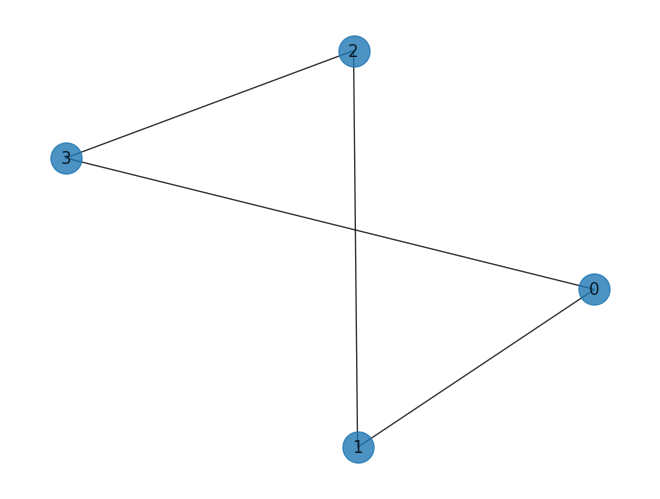

In [80]:
graph = nx.Graph()
graph.add_nodes_from([0, 1, 2, 3])
graph.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(graph, with_labels=True, alpha=0.8, node_size=500)
# Graphing the problem

C:\Users\naren\AppData\Local\Temp\ipykernel_22164\2514610450.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  connected_nodes = nx.adjacency_matrix(graph).todense()


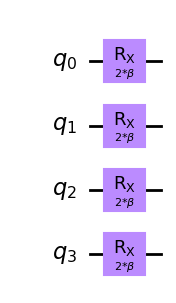

In [81]:
connected_nodes = nx.adjacency_matrix(graph).todense() 
# A matrix of what nodes are connected

qubit_count = 4
# Number of qubits (number of nodes)

beta = Parameter("$\\beta$") 
mixing_unitary = QuantumCircuit(qubit_count) # Creating the mixer Hamiltonian
for qubit in range(0, qubit_count):
    mixing_unitary.rx(2 * beta, qubit)

mixing_unitary.draw(output='mpl')

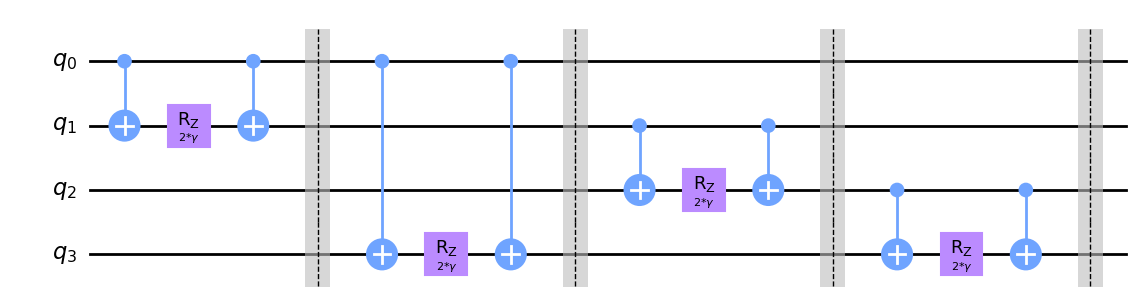

In [82]:
gamma = Parameter("$\\gamma$")
problem_unitary = QuantumCircuit(qubit_count) # Creating the problem Hamiltonian
for node_pair in list(graph.edges()):
    problem_unitary.rzz(2 * gamma, node_pair[0], node_pair[1])
    problem_unitary.barrier()

problem_unitary.decompose().draw(output='mpl')


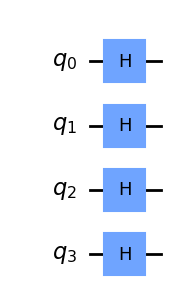

In [83]:
initial_state = QuantumCircuit(qubit_count) # Initial state of QAOA
for qubit in range(0, qubit_count):
    initial_state.h(qubit) # Superposition of all basis states

initial_state.draw(output='mpl')

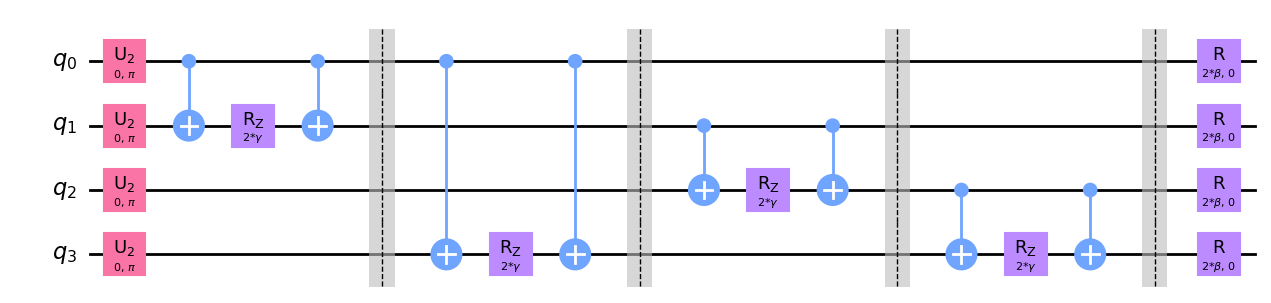

In [84]:
qaoa = QuantumCircuit(qubit_count)
# Prepare initial state
# Apply problem Hamiltonian
# Apply mixing Hamiltonian

qaoa.append(initial_state, [qubit for qubit in range(0, qubit_count)])
qaoa.append(problem_unitary, [qubit for qubit in range(0, qubit_count)])
qaoa.append(mixing_unitary, [qubit for qubit in range(0, qubit_count)])

qaoa.decompose().decompose().draw(output='mpl')

In [85]:
# Now, find optimal parameters
# 1) Initialize beta and gamma
# 2) Prepare state with beta, gamma
# 3) Compute the state
# 4) Get new parameters from classical optimizer
# 5) Repeat steps 2-4 until a criteria met

In [86]:
def test_maxcut(solution_string, graph):
    obj = 0
    for i, j in graph.edges():
        if solution_string[i] != solution_string[j]:
            obj -= 1
    return obj # Testing the solution on maxcut

def get_expectation(counts, graph):

    average = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = test_maxcut(bitstring[::-1], graph)
        average += obj * count
        sum_count += count
        
    return average/sum_count # Returns the expected value

def create_qaoa(graph, theta):
    qubit_count = len(graph.nodes())
    num_unitaries = len(theta)//2  # Number of alternating unitaries
    qc = QuantumCircuit(qubit_count)
    
    beta = theta[:num_unitaries]
    gamma = theta[num_unitaries:]
    
    # Initial state
    for qubit in range(0, qubit_count):
        qc.h(qubit)
    
    for i in range(0, num_unitaries):
        
        # Problem unitary
        for node_pair in list(graph.edges()):
            qc.rzz(2 * gamma[i], node_pair[0], node_pair[1])

        # Mixer unitary
        for qubit in range(0, qubit_count):
            qc.rx(2 * beta[i], qubit)
            
    qc.measure_all()
        
    return qc

def execute_circuit(graph, shots=512):
    backend= Aer.get_backend('qasm_simulator')
    backend.shots = shots

    def execute_helper(theta):
        qc = create_qaoa(graph, theta)
        counts = backend.run(qc, seed_simulator=10, nshots=512).result().get_counts()

        return get_expectation(counts, graph)

    return execute_helper

In [87]:
expectation = execute_circuit(graph)

optimizer = minimize(expectation, 
                      [1.0, 1.0], 
                      method='COBYLA') # Classical optimizer
optimizer

     fun: -2.994140625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 30
  status: 1
 success: True
       x: array([1.9793337 , 1.16663483])

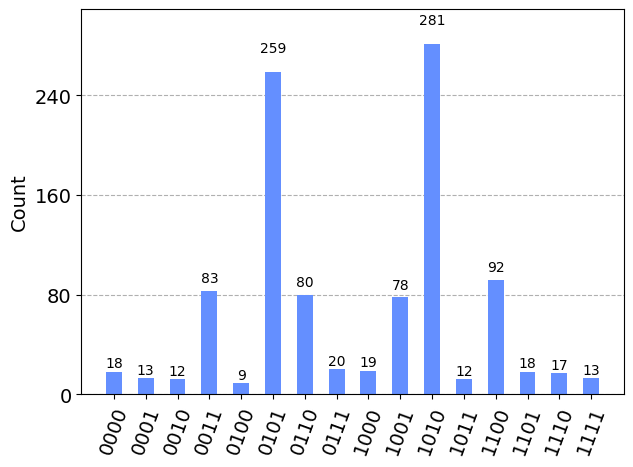

In [88]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa(graph, optimizer.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts) # Testing results

In [89]:
# The correct nodes!

# ![title](solution.png)

In [ ]:
# These are the two graphs that the results refer to